In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


/Users/tim/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


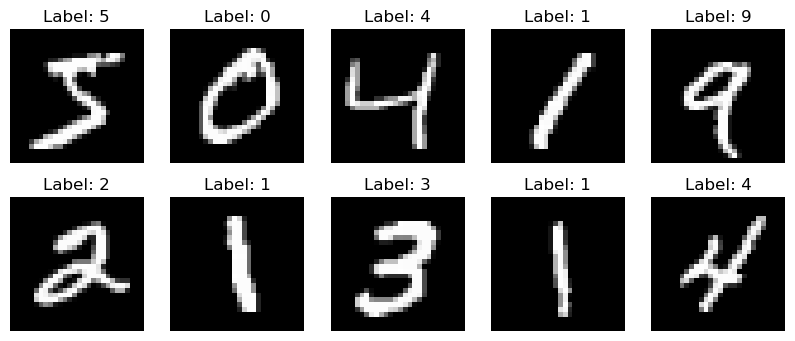

In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib.ticker as ticker


# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
# Convert data and target to numpy arrays
data = mnist.data
target = mnist.target.astype(np.uint8)  # convert labels from string to integer

# Split into training and testing sets
train_imgs = data[:60000]
train_labels = target[:60000]
test_imgs = data[60000:]
test_labels = target[60000:]

# Visualize some images and labels
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_imgs[i].reshape(28, 28), cmap='gray')
    ax.set_title("Label: {}".format(train_labels[i]))
    ax.axis('off')

plt.show()

# Convert numpy arrays to PyTorch tensors
train_imgs = torch.from_numpy(train_imgs).float()
train_labels = torch.from_numpy(train_labels)
test_imgs = torch.from_numpy(test_imgs).float()
test_labels = torch.from_numpy(test_labels)

# Create data loaders
train_dataset = TensorDataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32)

test_dataset = TensorDataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32)

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x


Training with learning rate: 0.0001
Epoch 1, Accuracy: 89.93%
Epoch 2, Accuracy: 91.72%
Epoch 3, Accuracy: 92.53%
Epoch 4, Accuracy: 93.01%
Epoch 5, Accuracy: 93.33%
Epoch 6, Accuracy: 93.67%
Epoch 7, Accuracy: 93.89%
Epoch 8, Accuracy: 94.12%
Epoch 9, Accuracy: 94.27%
Epoch 10, Accuracy: 94.42%
Epoch 11, Accuracy: 94.51%
Epoch 12, Accuracy: 94.59%
Epoch 13, Accuracy: 94.7%
Epoch 14, Accuracy: 94.78%
Epoch 15, Accuracy: 94.85%
Epoch 16, Accuracy: 94.89%
Epoch 17, Accuracy: 94.95%
Epoch 18, Accuracy: 94.99%
Epoch 19, Accuracy: 95.09%
Epoch 20, Accuracy: 95.14%
Epoch 21, Accuracy: 95.21%
Epoch 22, Accuracy: 95.24%
Epoch 23, Accuracy: 95.41%
Epoch 24, Accuracy: 95.38%
Epoch 25, Accuracy: 95.35%
Epoch 26, Accuracy: 95.43%
Epoch 27, Accuracy: 95.45%
Epoch 28, Accuracy: 95.5%
Epoch 29, Accuracy: 95.5%
Epoch 30, Accuracy: 95.5%
Epoch 31, Accuracy: 95.51%
Epoch 32, Accuracy: 95.53%
Epoch 33, Accuracy: 95.55%
Epoch 34, Accuracy: 95.52%
Epoch 35, Accuracy: 95.55%
Epoch 36, Accuracy: 95.54%
Epoch

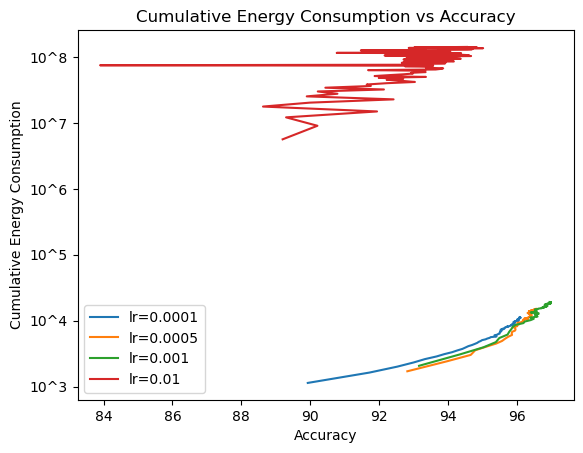

In [12]:
# Instantiate the network
input_dim = 784  # MNIST images are 28x28
hidden_dim = 100
output_dim = 10  # 10 classes

learning_rates = [0.0001, 0.0005, 0.001, 0.01]
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    model = FFNN(input_dim, hidden_dim, output_dim)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # Training
    epochs = 100
    best_accuracy = 0
    epochs_without_improvement = 0
    accuracies = []
    cumulative_energy_consumption = 0
    energy_consumptions = []
    for epoch in range(epochs):
        energy_consumption = 0
        for images, labels in train_loader:
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backpropagation
            loss.backward()
            # Save the current weights
            weights_before_update = [w.clone() for w in model.parameters()]
            # Update weights
            optimizer.step()
            # Calculate the size of the weight updates using L1 norm
            weight_updates = [weights_before_update[i] - w for i, w in enumerate(model.parameters())]
            weight_update_sizes = [w.abs().sum().item() for w in weight_updates]  # L1 norm
            # Estimate the energy consumption as the sum of the weight update sizes
            energy_consumption += sum(weight_update_sizes)
        cumulative_energy_consumption += energy_consumption
        energy_consumptions.append(cumulative_energy_consumption)

        # Test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy}%')

        # Early stopping
       # if accuracy > best_accuracy:
       #     best_accuracy = accuracy
       #     epochs_without_improvement = 0
       # else:
       #     epochs_without_improvement += 1
       #     if epochs_without_improvement >= 10:
       #         print(f'Stopping training after {epoch+1} epochs without improvement.')
       #         break

    plt.plot(accuracies, np.log10(energy_consumptions), label=f'lr={lr}')  # 10's power scale

def format_func(value, _):
    return f"10^{int(value)}"

plt.xlabel('Accuracy')
plt.ylabel('Cumulative Energy Consumption')
plt.title('Cumulative Energy Consumption vs Accuracy')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.legend()
plt.show()
